In [58]:
# 5. Trend Identification Using NLP: 
# • Goal: Use NLP to analyze TikTok video descriptions and hashtags to identify 
# emerging trends. 
# • Details: 
# o Apply topic modeling (e.g., Latent Dirichlet Allocation) to categorize video 
# descriptions and detect emerging topics. 
# o Perform sentiment analysis to evaluate the emotional tone of video content 
# and its correlation with engagement. 
# o Use Named Entity Recognition (NER) to track specific names, brands, or 
# events that might be linked to trending content. 

# Data and Library Preparation

In [59]:
# %pip install --upgrade pip setuptools wheel
# %pip install blis
# %pip install spacy==2.3.5
# %pip install gensim
# %pip install nltk
# %pip install textblob


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
from gensim import corpora, models
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob # For basic sentiment, though VADER is also an option


# Ensure necessary NLTK data is downloaded
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

# Load spaCy model (download if not already present)
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading en_core_web_sm model for spaCy...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

print("Libraries loaded and spaCy model initialized.")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Libraries loaded and spaCy model initialized.


In [61]:
# Load data
print("Loading data...")
try:
    df = pd.read_csv('data/processed/tiktok_enhanced_features.csv') # Assuming this is the correct path from q5.ipynb
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'tiktok_trends.csv' not found. Please ensure the file is in the correct directory.")

print(f"Data loaded. Shape: {df.shape}")

# Data Preprocessing and Feature Engineering (from both notebooks)
# Convert create_time to datetime and set as index for time-series analysis
df['create_time'] = pd.to_datetime(df['create_time'])
df = df.sort_values('create_time').reset_index(drop=True)

# Use the imported 'is_trending' column as-is (0 = not trending, 1 = trending)
# If needed, convert to boolean for analysis/visualization
if df['is_trending'].dtype != bool:
    df['is_trending'] = df['is_trending'].astype(bool)

print(f"Number of trending videos: {df['is_trending'].sum()}")
print(f"Number of non-trending videos: {(~df['is_trending']).sum()}")
print(f"Proportion of trending videos: {df['is_trending'].mean():.2%}")

print("\nFirst 5 rows with 'virality_score' and 'is_trending':")
print(df[['virality_score', 'is_trending']].head())


Loading data...
Data loaded successfully.
Data loaded. Shape: (7225, 77)
Number of trending videos: 1330
Number of non-trending videos: 5895
Proportion of trending videos: 18.41%

First 5 rows with 'virality_score' and 'is_trending':
   virality_score  is_trending
0      16960224.5         True
1       5374096.0         True
2      24157850.0         True
3      42056350.0         True
4      31651675.0         True


# Topic Modelling using LDA


Discovered Topics:
Topic 0: 0.034*"fyp" + 0.009*"viral" + 0.006*"trending" + 0.005*"foryoupage" + 0.005*"trend"
Topic 1: 0.078*"fyp" + 0.041*"description" + 0.026*"viral" + 0.018*"foryoupage" + 0.018*"foryou"
Topic 2: 0.007*"fyp" + 0.004*"bride" + 0.004*"day" + 0.003*"one" + 0.003*"game"
Topic 3: 0.013*"de" + 0.012*"la" + 0.009*"que" + 0.008*"el" + 0.007*"en"
Topic 4: 0.023*"fyp" + 0.008*"love" + 0.008*"im" + 0.007*"streameruniversity" + 0.007*"like"

Dominant topic distribution:
dominant_topic
1    2190
4    1643
0    1487
2    1043
3     862
Name: count, dtype: int64

Analyzing topic evolution...


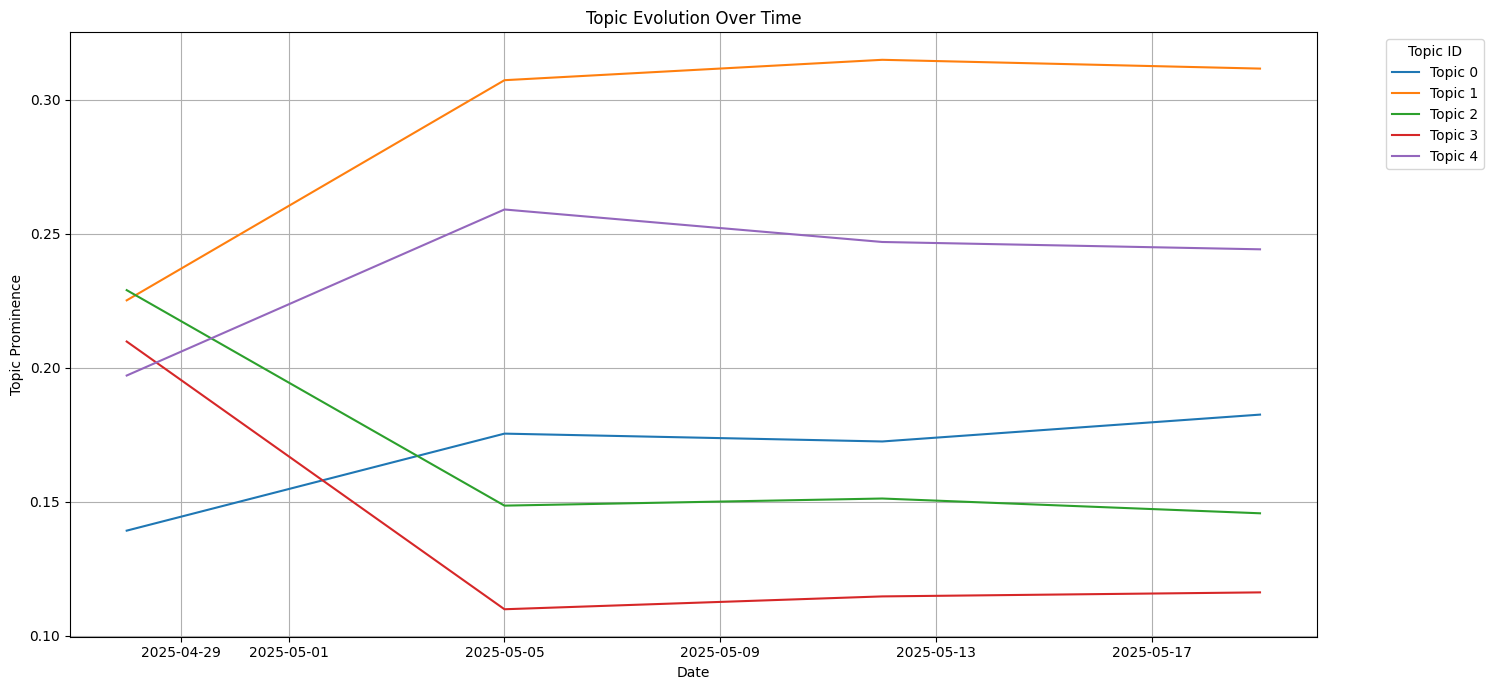

In [62]:
# Preprocessing for LDA
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_for_lda(text):
    text = str(text).lower() # Convert to string and lowercase
    text = re.sub(r'[^a-z\s]', '', text) # Remove non-alphabetic characters
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

df['processed_description'] = df['clean_description'].apply(preprocess_text_for_lda)

# Create Dictionary and Corpus
dictionary = corpora.Dictionary(df['processed_description'])
corpus = [dictionary.doc2bow(doc) for doc in df['processed_description']]

# Apply LDA (Latent Dirichlet Allocation)
NUM_TOPICS = 5 # As suggested in the project description (0-5 or more)
lda_model = models.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15, random_state=42)

print("\nDiscovered Topics:")
topics = lda_model.print_topics(num_words=5)
for topic_id, topic_words in topics:
    print(f"Topic {topic_id}: {topic_words}")

# Assign dominant topic to each document
def get_dominant_topic(bow):
    topics_per_document = lda_model.get_document_topics(bow)
    if not topics_per_document:
        return -1, 0.0 # Return -1 for cases with no topics assigned
    return max(topics_per_document, key=lambda x: x[1])

df['topic_distribution'] = [lda_model.get_document_topics(doc) for doc in corpus]
df['dominant_topic'] = [get_dominant_topic(doc)[0] for doc in corpus]

print("\nDominant topic distribution:")
print(df['dominant_topic'].value_counts())

# Visualization: Topic Evolution Over Time (from q5v2.ipynb)
print("\nAnalyzing topic evolution...")
df['date_group'] = df['create_time'].dt.to_period('W').dt.start_time # Group by week

topic_evolution = df.groupby('date_group')['dominant_topic'].value_counts(normalize=True).unstack(fill_value=0)
topic_evolution = topic_evolution.rolling(window=4).mean().dropna() # Simple rolling mean for smoothing

plt.figure(figsize=(15, 7))
for topic_idx in range(NUM_TOPICS):
    if topic_idx in topic_evolution.columns:
        plt.plot(topic_evolution.index, topic_evolution[topic_idx],
                 label=f'Topic {topic_idx}')
plt.title('Topic Evolution Over Time')
plt.xlabel('Date')
plt.ylabel('Topic Prominence')
plt.legend(title='Topic ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Sentiment Analysis

Sentiment polarity feature already exists in the dataset.
Average sentiment polarity: 0.051
Sentiment distribution:
count    7225.000000
mean        0.050656
std         0.225172
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: sentiment_polarity, dtype: float64

Sentiment label distribution:
sentiment_label
Neutral     4898
Positive    1676
Negative     651
Name: count, dtype: int64

Comparing sentiment between trending and non-trending videos:
Average sentiment in trending videos: 0.048
Average sentiment in non-trending videos: 0.051


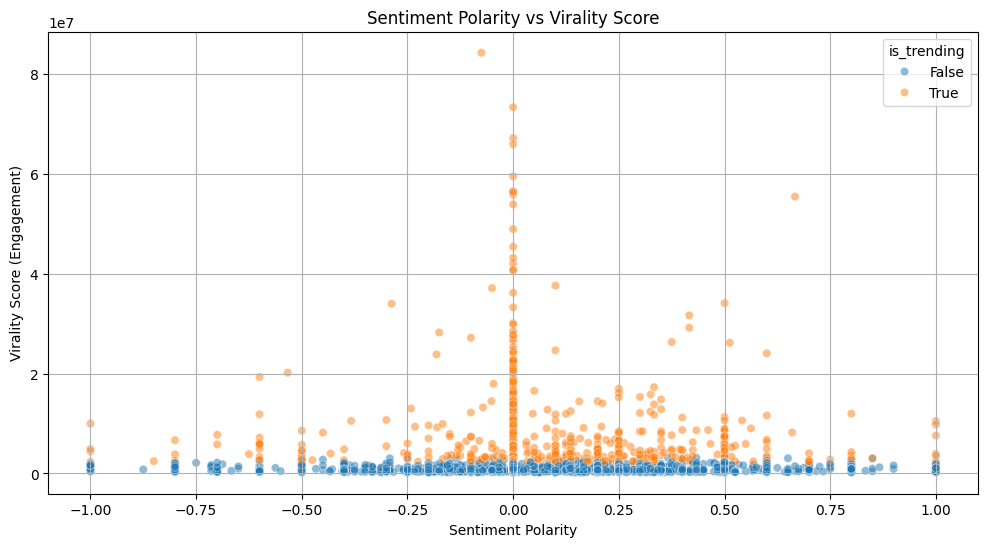

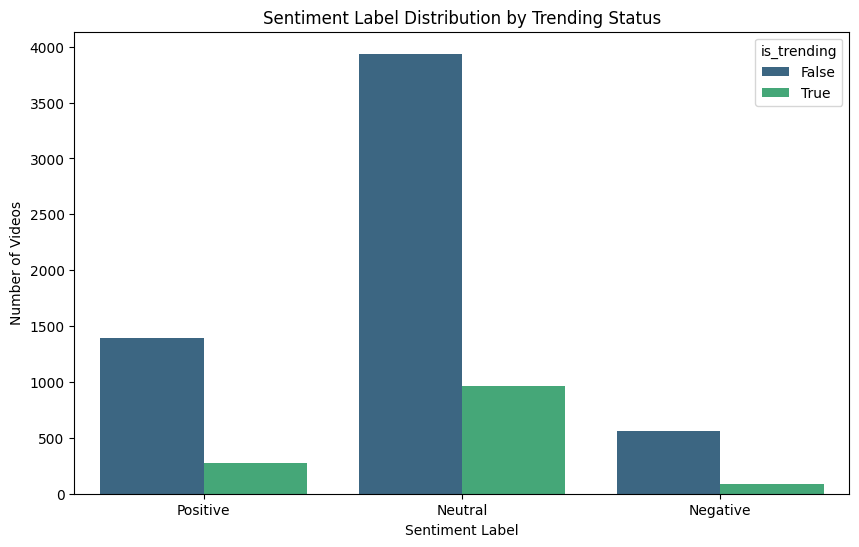

In [63]:
if 'sentiment_polarity' not in df.columns:
    print("Sentiment polarity feature not found. Calculating sentiment polarity using TextBlob...")
    # Fallback if sentiment_polarity is not pre-existing
    df['sentiment_polarity'] = df['video_description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
else:
    print("Sentiment polarity feature already exists in the dataset.")

print(f"Average sentiment polarity: {df['sentiment_polarity'].mean():.3f}")
print("Sentiment distribution:")
print(df['sentiment_polarity'].describe())

# Create 'sentiment_label' feature (Positive/Neutral/Negative) as requested
def get_sentiment_label(polarity):
    if polarity > 0.05: # Adjusted threshold for 'Positive'
        return 'Positive'
    elif polarity < -0.05: # Adjusted threshold for 'Negative'
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_polarity'].apply(get_sentiment_label)
print("\nSentiment label distribution:")
print(df['sentiment_label'].value_counts())

# Compare sentiment between trending and non-trending videos
print("\nComparing sentiment between trending and non-trending videos:")
sentiment_trending = df[df['is_trending']]['sentiment_polarity']
sentiment_non_trending = df[~df['is_trending']]['sentiment_polarity']

print(f"Average sentiment in trending videos: {sentiment_trending.mean():.3f}")
print(f"Average sentiment in non-trending videos: {sentiment_non_trending.mean():.3f}")

# Visualization: Sentiment Polarity vs Virality Score (from q5v2.ipynb)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='sentiment_polarity', y='virality_score',
                hue='is_trending', alpha=0.5)
plt.title('Sentiment Polarity vs Virality Score')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Virality Score (Engagement)')
plt.grid(True)
plt.show()

# Visualization: Sentiment Label Distribution by Trending Status
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment_label', hue='is_trending', palette='viridis')
plt.title('Sentiment Label Distribution by Trending Status')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Videos')
plt.show()

# Named Entity Recognition (NER)


Top 20 most frequent entities:
- one: 79
- summer: 68
- first: 61
- today: 37
- pov: 33
- nba: 28
- un: 23
- two: 20
- onthisday: 17
- chicago: 17
- us: 15
- kaicenat: 15
- blowthisup: 14
- friday: 13
- mexico: 13
- classof: 13
- streamer university: 13
- the day: 12
- atlanta: 12
- english: 11

Top 10 entities in Trending Videos:
- un: 16
- summer: 13
- one: 12
- first: 9
- today: 7
- que: 7
- pov: 6
- comedia: 6
- harvard: 6
- two: 5

Top 10 entities in Non-Trending Videos:
- one: 67
- summer: 55
- first: 52
- today: 30
- pov: 27
- nba: 27
- onthisday: 17
- chicago: 16
- two: 15
- us: 13

Analyzing potential emerging entities (Lift analysis):
Top 10 Emerging Entities (with lift > 1.5 and trending count > 5):
- comedia: Lift = 20.54
- harvard: Lift = 10.27
- que: Lift = 7.99
- un: Lift = 7.82

Analyzing entity mention volume over time...


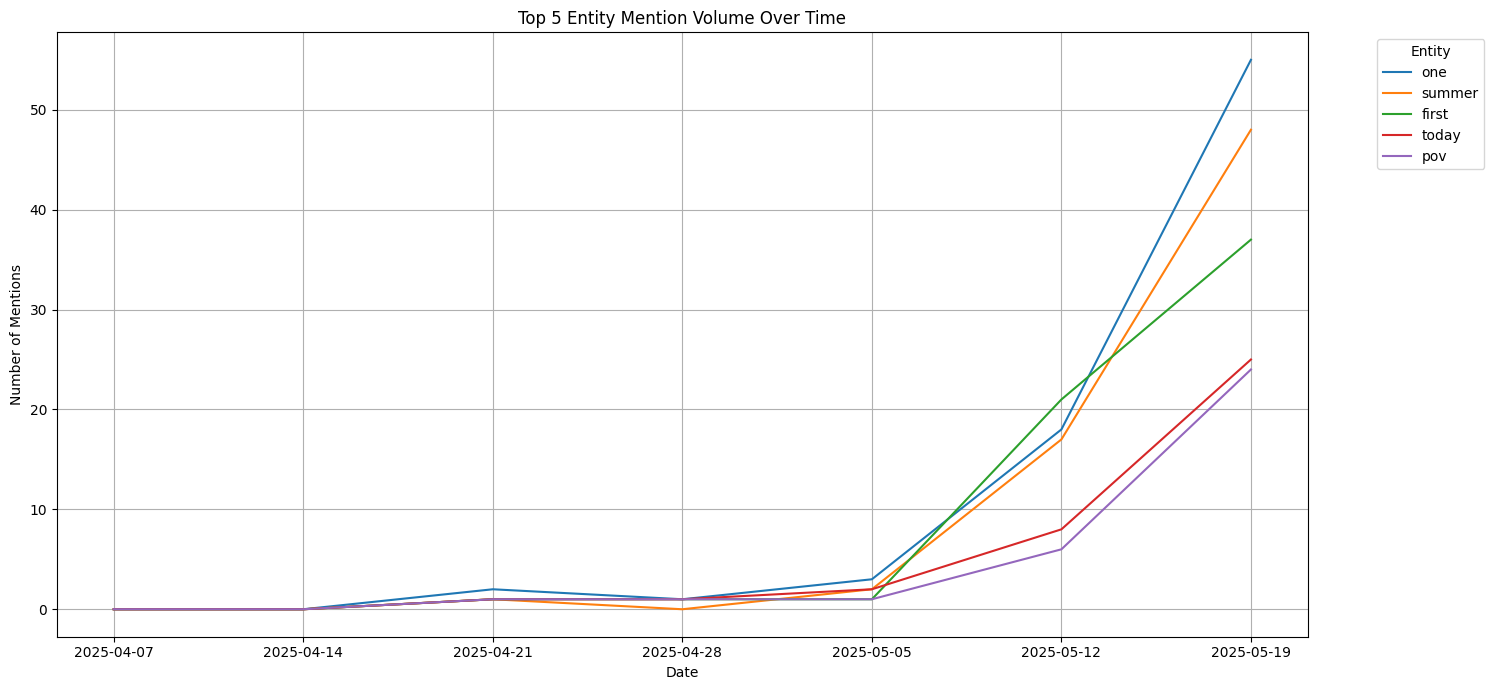

In [64]:
def extract_entities(text):
    doc = nlp(str(text))
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

df['extracted_entities'] = df['clean_description'].apply(extract_entities)

all_entities = [entity[0] for sublist in df['extracted_entities'] for entity in sublist]
entity_counts = Counter(all_entities)
print("\nTop 20 most frequent entities:")
for entity, count in entity_counts.most_common(20):
    print(f"- {entity}: {count}")

# Extract entities specifically from trending and non-trending videos
trending_entities = [entity[0] for sublist in df[df['is_trending']]['extracted_entities'] for entity in sublist]
non_trending_entities = [entity[0] for sublist in df[~df['is_trending']]['extracted_entities'] for entity in sublist]

trending_entity_counts = Counter(trending_entities)
non_trending_entity_counts = Counter(non_trending_entities)

print("\nTop 10 entities in Trending Videos:")
for entity, count in trending_entity_counts.most_common(10):
    print(f"- {entity}: {count}")

print("\nTop 10 entities in Non-Trending Videos:")
for entity, count in non_trending_entity_counts.most_common(10):
    print(f"- {entity}: {count}")

# Identify emerging entities (entities more prevalent in trending content)
print("\nAnalyzing potential emerging entities (Lift analysis):")
all_unique_entities = set(trending_entity_counts.keys()).union(set(non_trending_entity_counts.keys()))
emerging_entities = {}

total_trending = sum(trending_entity_counts.values())
total_non_trending = sum(non_trending_entity_counts.values())

if total_trending == 0: total_trending = 1 # Avoid division by zero
if total_non_trending == 0: total_non_trending = 1 # Avoid division by zero

for entity in all_unique_entities:
    count_trending = trending_entity_counts.get(entity, 0)
    count_non_trending = non_trending_entity_counts.get(entity, 0)

    if count_trending > 0 and count_non_trending > 0:
        prop_trending = count_trending / total_trending
        prop_non_trending = count_non_trending / total_non_trending

        if prop_non_trending > 0: # Avoid division by zero
            lift = prop_trending / prop_non_trending
            # Filter for entities with significant lift and reasonable counts
            if lift > 1.5 and count_trending > 5: # Example thresholds
                emerging_entities[entity] = lift

sorted_emerging_entities = sorted(emerging_entities.items(), key=lambda item: item[1], reverse=True)
print("Top 10 Emerging Entities (with lift > 1.5 and trending count > 5):")
for entity, lift in sorted_emerging_entities[:10]:
    print(f"- {entity}: Lift = {lift:.2f}")

# Visualization: Entity Mention Volume Over Time (from q5v2.ipynb, adapted)
print("\nAnalyzing entity mention volume over time...")

# Flatten entities and associate with date_group
entity_data = []
for index, row in df.iterrows():
    for entity_text, entity_label in row['extracted_entities']:
        entity_data.append({'date_group': row['date_group'], 'entity': entity_text})

if entity_data:
    entity_df = pd.DataFrame(entity_data)
    # Aggregate entity mentions by date_group (week)
    entity_trends_over_time = entity_df.groupby(['date_group', 'entity']).size().unstack(fill_value=0)

    # Select top N entities for visualization
    top_entities_for_plot = entity_counts.most_common(5)
    top_entity_names = [ent[0] for ent in top_entities_for_plot]

    plt.figure(figsize=(15, 7))
    for entity_name in top_entity_names:
        if entity_name in entity_trends_over_time.columns:
            plt.plot(entity_trends_over_time.index.astype(str), entity_trends_over_time[entity_name], label=entity_name)
    plt.title('Top 5 Entity Mention Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Mentions')
    plt.legend(title='Entity', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No entities extracted for time series analysis. Skipping entity trend visualization.")

# Saved Data into new table

In [65]:
# --- Optional: Save the dataframe with all new NLP features ---
output_path = 'data/processed/tiktok_processed_with_nlp_features.csv'
# Ensure all original columns are included
required_columns = [
    'video_id','author','likes','comments','shares','plays','clean_description','hashtag_list','hashtag_count','create_time','create_hour','create_day','create_month','create_year','day_of_week','is_weekend','time_period','total_engagement','engagement_rate_per_play','weighted_engagement','weighted_engagement_rate','commenting_rate','sharing_rate','viral_coefficient','viral_coefficient_norm','is_viral_plays','is_highly_engaging','total_engagement_capped','engagement_rate_per_play_capped','description_length','word_count','readability_score','sentiment_polarity','sentiment_subjectivity','has_question','has_exclamation','exclamation_count','has_tag_fyp','has_tag_viral','has_tag_fypシ','has_tag_foryoupage','has_tag_foryou','has_tag_trending','has_tag_relatable','has_tag_funny','has_tag_tiktok','has_tag_fypシviral','hashtag_list_clean','hashtag_categories','is_dance','is_comedy','is_beauty','is_food','is_fitness','is_education','is_pets','is_travel','is_relationship','is_music','is_gaming','is_sports','is_diy','is_fashion','content_description','content_cluster','content_category','engagement_cluster','engagement_pattern','primary_hashtag_category','unified_category','virality_score','virality_score_normalized','is_trending','author_avg_virality','author_max_virality','author_total_videos','author_viral_ratio'
]
# Add new NLP trend columns
nlp_columns = [
    'sentiment_label', 'dominant_topic', 'extracted_entities'
]
# Only keep columns that exist in the dataframe
all_columns = [col for col in required_columns if col in df.columns] + [col for col in nlp_columns if col in df.columns]
df_to_save = df[all_columns]
# Add a new column for trend identification summary (example: combine NLP features)
def trend_nlp_summary(row):
    return f"Sentiment: {row['sentiment_label']}, Topic: {row['dominant_topic']}, Entities: {', '.join([e[0] for e in row['extracted_entities']]) if isinstance(row['extracted_entities'], list) else ''}"
df_to_save['trend_nlp_summary'] = df.apply(trend_nlp_summary, axis=1)
try:
    # Ensure the directory exists
    import os
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_to_save.to_csv(output_path, index=False)
    print(f"\nUpdated DataFrame with all NLP features saved to: {output_path}")
except Exception as e:
    print(f"Error saving DataFrame: {e}")

print("\nNLP trend identification complete. Review the generated plots and data for insights.")

Error saving DataFrame: [Errno 13] Permission denied: 'data/processed/tiktok_processed_with_nlp_features.csv'

NLP trend identification complete. Review the generated plots and data for insights.


C:\Users\user\AppData\Local\Temp\ipykernel_35696\1447335952.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_save['trend_nlp_summary'] = df.apply(trend_nlp_summary, axis=1)
